In [22]:
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
from skimage import color
import cv2
from statistics import mean
from sklearn.preprocessing import StandardScaler

In [23]:
os.getcwd()

'/Users/leoniedevolder/Documents/Thesis/Python/UMAPs'

In [24]:
# Laad CSV-bestand
df = pd.read_csv("../sensor_data/airflowrate_basin4.csv", parse_dates=["Time"])

# Juiste kolomnaam
naam_kolom = df.columns[1]

# 0-waarden
df = df.dropna()
df = df[df[naam_kolom] != 0]
df = df[~((df["Time"] >= "2024-04-06") & (df["Time"] <= "2024-04-29"))]

# Controleer of 'Time' kolom datetime is, anders omzetten
if not pd.api.types.is_datetime64_any_dtype(df['Time']):
    df['Time'] = pd.to_datetime(df['Time'])

# Haal de datum uit de 'Time' kolom (zonder tijdcomponent)
df['Date'] = df['Time'].dt.date

# Bereken het gemiddelde van 'airflow_basin5' voor elke datum
gem_dagelijks = df.groupby('Date')['airflow_basin4'].mean().reset_index()

In [25]:
def load_and_process_images_newmicroscope(base_dir, target_size=(100, 100)):
    images = []
    original_images = []
    labels = []

    # Loop door alle datum-mappen in de base_dir
    for datum_map in os.listdir(base_dir):
        if datum_map.startswith('.'):
            continue  # negeer verborgen mappen
        datum_pad = os.path.join(base_dir, datum_map)
        if not os.path.isdir(datum_pad):
            continue

        # Kijk in zowel basin3 als basin5
        for bassin_folder in ['basin3', 'basin5']:
            bassin_pad = os.path.join(datum_pad, bassin_folder, '10x')
            if os.path.exists(bassin_pad):
                for foto in os.listdir(bassin_pad):
                    fotopad = os.path.join(bassin_pad, foto)
                    im = cv2.imread(fotopad, cv2.IMREAD_UNCHANGED)
                    if im is not None:
                        original_images.append(im)

                        # Convert naar grijs (indien nog in kleur) en resize
                        if len(im.shape) == 3:
                            im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                        else:
                            im_gray = im  # al grijs

                        im_resized = cv2.resize(im_gray, target_size, interpolation=cv2.INTER_LINEAR)

                        images.append(im_resized)
                        labels.append(datum_map)  # label is de datum

    return np.array(images), original_images, labels

target_size = (250, 150)
base_dir = "/Users/leoniedevolder/Documents/Thesis/Python/microscope_images/newmicroscope"
imagesnew, originalsnew, labelsnew = load_and_process_images_newmicroscope(base_dir, target_size)


In [26]:
def load_and_process_images_oldmicroscope(base_dir, target_size=(100, 100)):
    images = []
    original_images = []
    labels = []

    # Loop door alle datum-mappen in de base_dir
    for datum_map in os.listdir(base_dir):
        if datum_map.startswith('.'):
            continue  # negeer verborgen mappen
        datum_pad = os.path.join(base_dir, datum_map)
        if not os.path.isdir(datum_pad):
            continue

        # Kijk in zowel basin3 als basin5
        for bassin_folder in ['basin3', 'basin5']:
            bassin_pad = os.path.join(datum_pad, bassin_folder)
            if os.path.exists(bassin_pad):
                for foto in os.listdir(bassin_pad):
                    fotopad = os.path.join(bassin_pad, foto)
                    im = cv2.imread(fotopad, cv2.IMREAD_UNCHANGED)
                    if im is not None:
                        original_images.append(im)

                        # Convert naar grijs (indien nog in kleur) en resize
                        if len(im.shape) == 3:
                            im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                        else:
                            im_gray = im  # al grijs

                        im_resized = cv2.resize(im_gray, target_size, interpolation=cv2.INTER_LINEAR)

                        images.append(im_resized)
                        labels.append(datum_map)  # label is de datum

    return np.array(images), original_images, labels

target_size = (250, 150)
base_dir = "/Users/leoniedevolder/Documents/Thesis/Python/microscope_images/oldmicroscopedata"
imagesold, originalsold, labelsold = load_and_process_images_oldmicroscope(base_dir, target_size)


In [27]:
print(imagesnew[0].shape)
print(originalsnew[0].shape)
print(len(imagesnew))

print(imagesold[0].shape)
print(originalsold[0].shape)
print(len(imagesold))


(150, 250)
(960, 1280, 3)
3434
(150, 250)
(768, 1024, 3)
1132


In [28]:
# Combineer de grijs-geschaalde en geresize-de afbeeldingen (NumPy-arrays)
images = np.concatenate([imagesold, imagesnew], axis=0)

# Combineer de originele kleurafbeeldingen (lijsten)
originals = originalsold + originalsnew

# Combineer de labels (lijsten)
labels = labelsold + labelsnew

In [29]:
# Zet de labels om naar een DataFrame
df_labels = pd.DataFrame(labels, columns=['Date'])

# Zet de datums om naar datetime (indien nog geen datetime-formaat)
df_labels['Date'] = pd.to_datetime(df_labels['Date'], errors='coerce')  # 'coerce' zet ongeldige waarden om naar NaT

# Verwijder eventuele NaT-waarden
df_labels = df_labels.dropna(subset=['Date'])

# Behoud enkel unieke datums, gesorteerd
df_labels = df_labels.drop_duplicates().sort_values(by='Date').reset_index(drop=True)

# Optioneel: opslaan als CSV
df_labels.to_csv("unique_microscope_image_dates.csv", index=False)

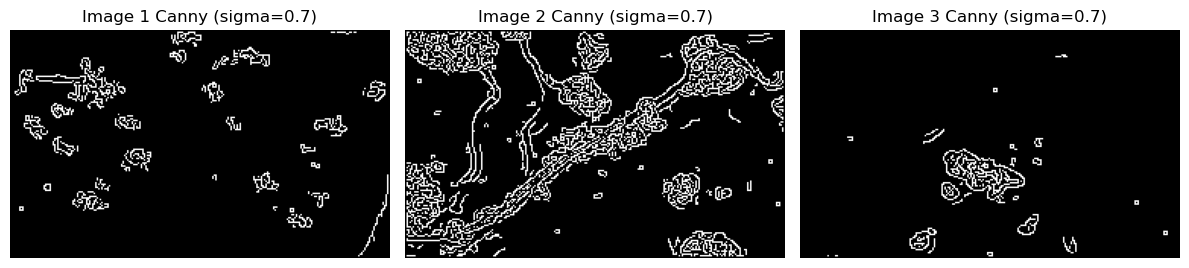

In [30]:
import random
from skimage import feature
import matplotlib.pyplot as plt

# Functie om Canny edge detection toe te passen met sigma = 0.7
def apply_canny_with_sigma(image, sigma=0.7):
    return feature.canny(image, sigma=sigma)  # Skimage Canny edge detection

# Normaliseer en pas Canny toe op alle afbeeldingen in X met sigma = 0.7
X_canny = [apply_canny_with_sigma(img / 255.0, sigma=0.7) for img in images]  # Normaliseer naar [0, 1] en pas Canny toe

# Selecteer willekeurige indices
num_samples = 3 # Aantal willekeurige afbeeldingen
random_indices = random.sample(range(len(X_canny)), num_samples)  # Willekeurige indices selecteren

# Visualiseer de resultaten van de willekeurige afbeeldingen na Canny (sigma = 0.7)
plt.figure(figsize=(num_samples * 4, 4))

for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_canny[idx], cmap='gray')
    plt.title(f"Image {i+1} Canny (sigma=0.7)")
    plt.axis("off")

plt.tight_layout()
plt.show()

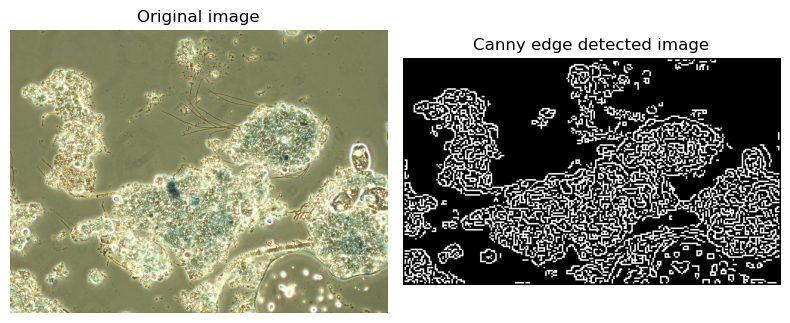

In [31]:
# Kies één willekeurige index
random_idx = random.randint(0, len(images) - 1)

# Verkrijg originele en edge-detected afbeelding
original = originals[random_idx]
image = images[random_idx]
canny = apply_canny_with_sigma(image/255, sigma=0.7)

# Plot beide
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original, cmap='gray')
plt.title("Original image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(canny, cmap='gray')
plt.title("Canny edge detected image")
plt.axis("off")

plt.tight_layout()
plt.show()

In [32]:
# Nu willen we de gemiddelde airflow per dag koppelen aan de labels (datums)
gem_dagelijks_dict = dict(zip(gem_dagelijks['Date'], gem_dagelijks['airflow_basin4']))

# Koppel de gemiddelde airflow naar de labels van de afbeeldingen
image_labels = []

for datum in labels:
    datum = pd.to_datetime(datum).date()  # Zorg ervoor dat het een date-object is
    
    # Zoek de gemiddelde airflow voor die datum
    airflow_for_datum = gem_dagelijks_dict.get(datum, None)
    
    if airflow_for_datum is not None:
        image_labels.append(airflow_for_datum)  # Voeg het gemiddelde toe als label voor de afbeelding
    else:
        image_labels.append(None)  # Als er geen airflow voor die datum is, voeg None toe

# Omzetten naar numpy array voor consistentie
image_labels = np.array(image_labels)

# Bekijk de resultaten (labels voor je afbeeldingen)
print(image_labels.shape)

(4566,)


/opt/anaconda3/envs/thesis/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


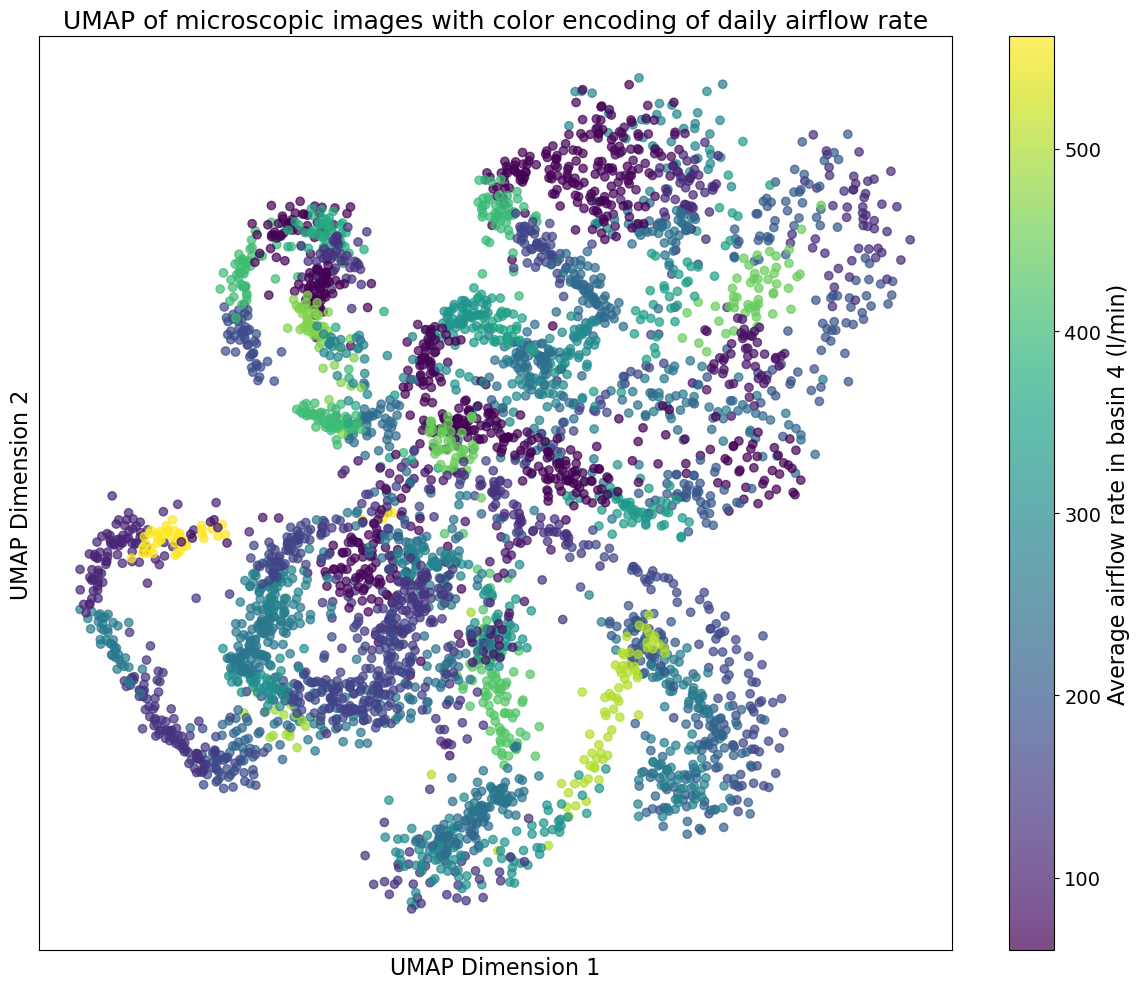

In [33]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Functie om afbeeldingen om te zetten naar 1D-vectors (flatten) voor UMAP
def flatten_images(images):
    return np.array([img.flatten() for img in images])

# **UMAP dimensionality reduction**
def apply_umap(X, n_neighbors=30, min_dist=0.1, random_state=32):
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state  # vaste seed
    )
    return reducer.fit_transform(X)

# Flatten alle afbeeldingen na Canny edge detection
X_canny_flattened = flatten_images(X_canny)

X_umap = apply_umap(X_canny_flattened, n_neighbors=30, min_dist=0.1, random_state=42)

# Filter out None values and their corresponding entries in X_canny_flattened
valid_indices = [i for i, label in enumerate(image_labels) if label is not None]
image_labels_filtered = [image_labels[i] for i in valid_indices]
X_umap_filtered = X_umap[valid_indices]

# Gebruik de image_labels die we eerder hebben gemaakt
# Zorg ervoor dat image_labels een array van numerieke waarden heeft (bijv. gemiddelde airflow)

# Kleur toewijzing gebaseerd op de airflow data
# Hier gebruiken we een colormap (bijvoorbeeld 'viridis') om een kleurenschaal toe te passen
colormap = plt.get_cmap("viridis")

plt.figure(figsize=(12, 10))

norm = plt.Normalize(vmin=min(image_labels_filtered), vmax=max(image_labels_filtered))

scatter = plt.scatter(X_umap_filtered[:, 0], X_umap_filtered[:, 1], c=image_labels_filtered,
                      cmap=colormap, norm=norm, alpha=0.7)

plt.xlabel("UMAP Dimension 1", fontsize=16)
plt.ylabel("UMAP Dimension 2", fontsize=16)
plt.title("UMAP of microscopic images with color encoding of daily airflow rate", fontsize=18)

cbar = plt.colorbar(scatter)
cbar.set_label('Average airflow rate in basin 4 (l/min)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Verwijder asnummers
plt.xticks([])
plt.yticks([])

plt.tight_layout()

# Sla op als PDF
plt.savefig("UMAPDailyAirflowBasin4oldnew.pdf", format='pdf', bbox_inches='tight')

# Toon de plot
plt.show()

/opt/anaconda3/envs/thesis/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finit

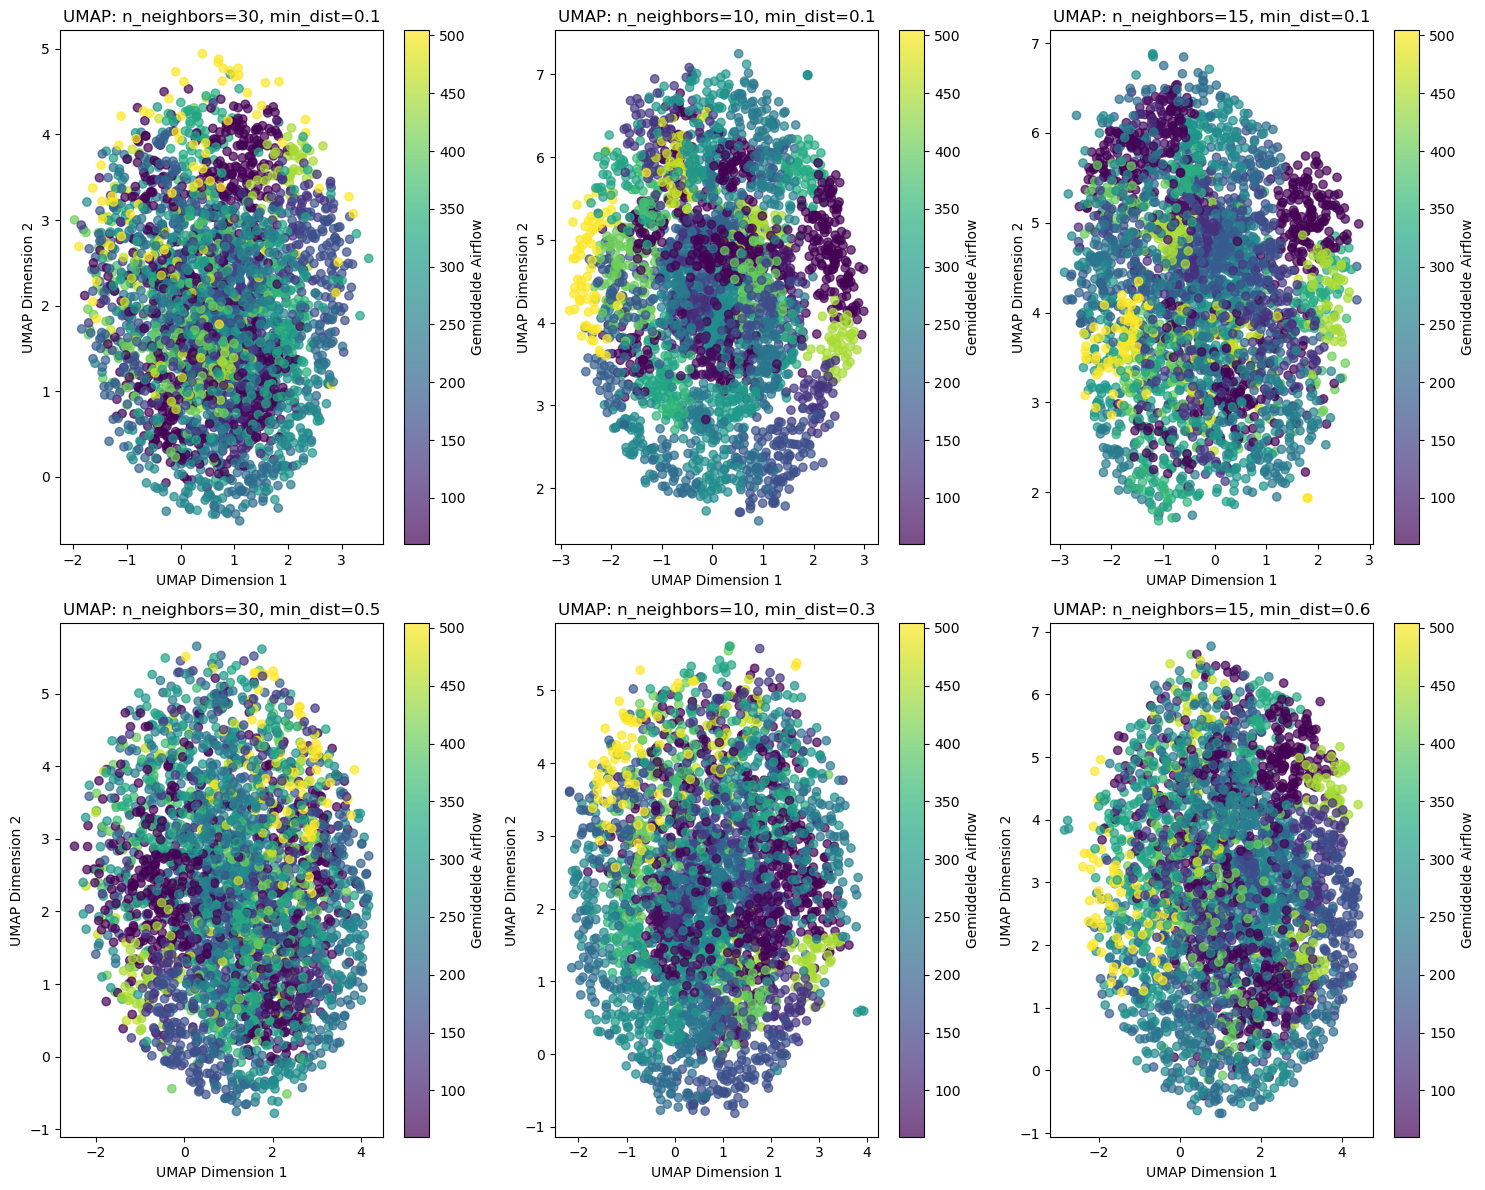

In [28]:
colormap = plt.get_cmap("viridis")
norm = plt.Normalize(vmin=min(image_labels_filtered), vmax=max(image_labels_filtered))

# Lijst met parametercombinaties voor n_neighbors en min_dist
param_combinations = [
    (30, 0.1),
    (10, 0.1),
    (15, 0.1),
    (30, 0.5),
    (10, 0.3),
    (15, 0.6)
]

# **2D Visualisatie voor UMAP met kleur gebaseerd op gemiddelde airflow**
plt.figure(figsize=(15, 12))

for i, (n_neighbors, min_dist) in enumerate(param_combinations, 1):
    # Pas UMAP toe
    X_umap = apply_umap(X_canny_flattened_filtered, n_neighbors=n_neighbors, min_dist=min_dist)

    plt.subplot(2, 3, i)  # Maak een subplot voor elke combinatie
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=image_labels_filtered, cmap=colormap, norm=norm, alpha=0.7)

    # Voeg labels toe aan de assen en de titel
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.title(f"UMAP: n_neighbors={n_neighbors}, min_dist={min_dist}")

    # Voeg een colorbar toe om de kleurenschaal te tonen
    cbar = plt.colorbar(scatter)
    cbar.set_label('Gemiddelde Airflow')

plt.tight_layout()
plt.show()

In [34]:
from scipy.stats import trim_mean
# Laad CSV-bestand
dfDO = pd.read_csv("../sensor_data/DO_basin4.csv", parse_dates=["Time"])

# Juiste kolomnaam
naam_kolom_DO = dfDO.columns[1]

# 0-waarden
dfDO = dfDO.dropna()
dfDO = dfDO[dfDO[naam_kolom_DO] != 0]
dfDO = dfDO[dfDO[naam_kolom_DO] < 3.5]
dfDO = dfDO[~((dfDO["Time"] >= "2024-04-06") & (dfDO["Time"] <= "2024-04-29"))]

rolling_median = dfDO[naam_kolom_DO].rolling(window=150, center=True).median()
diff = np.abs(dfDO[naam_kolom_DO] - rolling_median)
threshold = 0.5
dfDO = dfDO[diff < threshold]

def trimmed_daily_mean(values, proportion_to_cut=0.00000005):
    return trim_mean(values, proportiontocut=proportion_to_cut)

# Controleer of 'Time' kolom datetime is, anders omzetten
if not pd.api.types.is_datetime64_any_dtype(dfDO['Time']):
    dfDO['Time'] = pd.to_datetime(dfDO['Time'])

# Haal de datum uit de 'Time' kolom (zonder tijdcomponent)
dfDO['Date'] = dfDO['Time'].dt.date

# Pas deze functie toe in je groupby
gem_dagelijks_DO = dfDO.groupby('Date')[naam_kolom_DO].apply(trimmed_daily_mean).reset_index()

In [35]:
# Nu willen we de gemiddelde airflow per dag koppelen aan de labels (datums)
gem_dagelijks_airflow_dict = dict(zip(gem_dagelijks['Date'], gem_dagelijks['airflow_basin4']))
gem_dagelijks_DO_dict = dict(zip(gem_dagelijks_DO['Date'], gem_dagelijks_DO['DO_basin4']))

image_labels2 = []

for datum in labels:
    datum = pd.to_datetime(datum).date()
    airflow = gem_dagelijks_airflow_dict.get(datum, None)
    DO = gem_dagelijks_DO_dict.get(datum, None)

    if airflow is not None and DO is not None and DO != 0:
        image_labels2.append(airflow/DO)
    else:
        image_labels2.append(None)

image_labels2 = np.array(image_labels2)
print(image_labels2)
print(image_labels2.shape)

[213.936241599071 213.936241599071 213.936241599071 ... 171.84055836353772
 171.84055836353772 171.84055836353772]
(4566,)


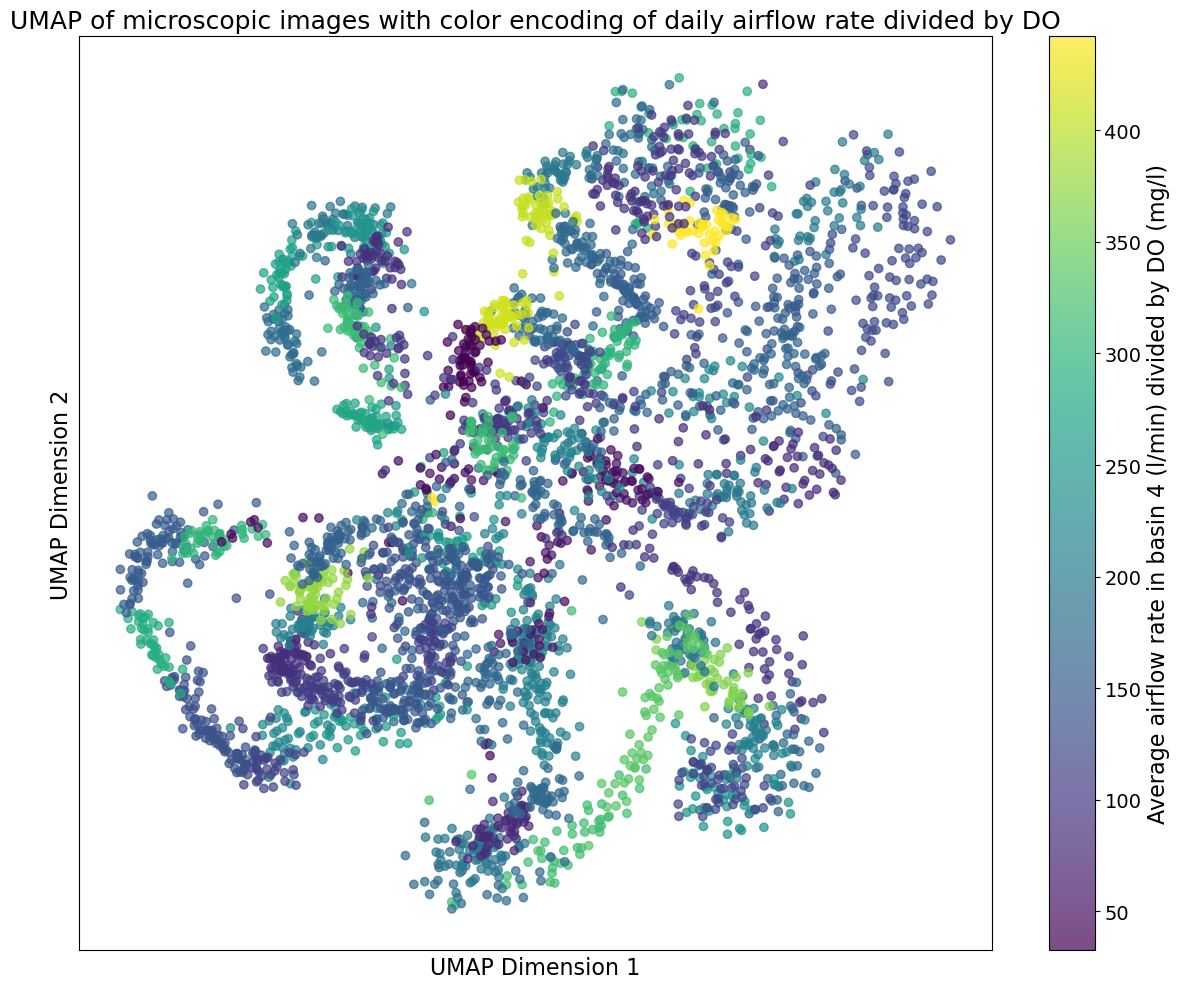

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# --- Zorg dat dit al bestaat ---
# X_umap: 2D array met bestaande UMAP-coördinaten (bijv. van airflow plot)
# image_labels2: nieuwe labels (bijv. airflow / DO)
# labels: lijst met datums van je afbeeldingen (zoals eerder)
# Opgelet: je moet deze code uitvoeren NA de code waar je image_labels2 maakt

# 1. Filter op geldige entries
valid_indices = [i for i, label in enumerate(image_labels2) if label is not None]
image_labels_filtered = [image_labels2[i] for i in valid_indices]
X_umap_filtered = X_umap[valid_indices]

# 2. Plot met aangepaste kleurenschaal
colormap = plt.get_cmap("viridis")
norm = plt.Normalize(vmin=min(image_labels_filtered), vmax=max(image_labels_filtered))

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_umap_filtered[:, 0], X_umap_filtered[:, 1],
                      c=image_labels_filtered, cmap=colormap, norm=norm, alpha=0.7)

# As- en titellabels
plt.xlabel("UMAP Dimension 1", fontsize=16)
plt.ylabel("UMAP Dimension 2", fontsize=16)
plt.title("UMAP of microscopic images with color encoding of daily airflow rate divided by DO", fontsize=18)

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Average airflow rate in basin 4 (l/min) divided by DO (mg/l)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Asnummers verwijderen
plt.xticks([])
plt.yticks([])

# Layout en opslaan
plt.tight_layout()
plt.savefig("UMAPDailyAirflowDOBasin4oldnew.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [37]:
from datetime import timedelta

# Zorg dat de datumkolom van gem_dagelijks het juiste type is
gem_dagelijks['Date'] = pd.to_datetime(gem_dagelijks['Date']).dt.date

# Zet de airflow-waarden in een dictionary
gem_dagelijks_dict = dict(zip(gem_dagelijks['Date'], gem_dagelijks['airflow_basin4']))

# Voor elke datum in labels: bereken het gemiddelde over de datum + 6 volgende dagen (indien compleet)
image_labels3 = []

for datum in labels:
    datum = pd.to_datetime(datum).date()
    venster = [datum + timedelta(days=i) for i in range(7)]
    
    # Check of alle 7 dagen beschikbaar zijn
    if all(d in gem_dagelijks_dict for d in venster):
        waarden = [gem_dagelijks_dict[d] for d in venster]
        image_labels3.append(np.mean(waarden))
    else:
        image_labels3.append(None)

# Omzetten naar numpy array
image_labels3 = np.array(image_labels3)

# Controle
print(image_labels3.shape)

(4566,)


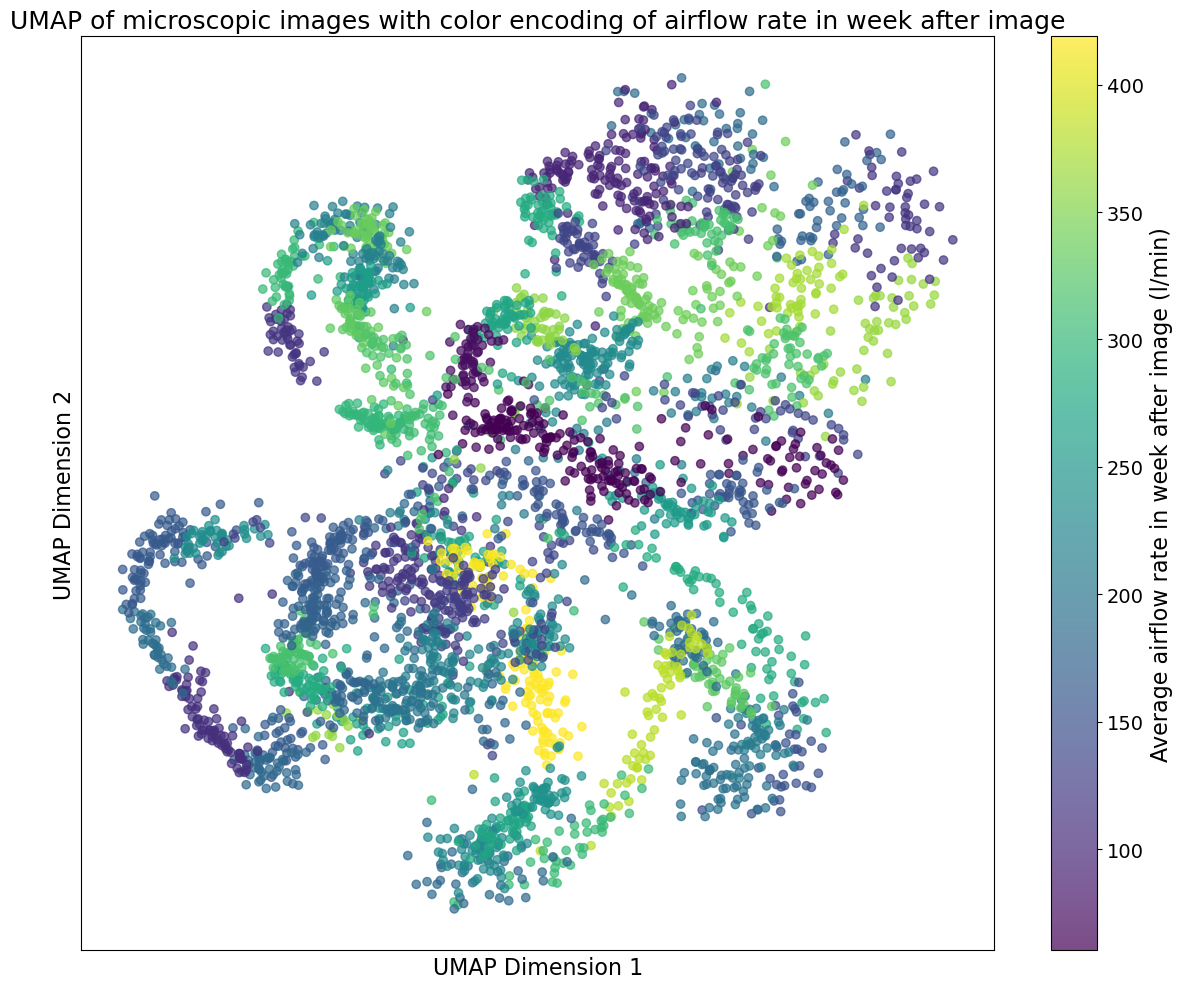

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# --- Zorg dat dit al bestaat ---
# X_umap: 2D array met bestaande UMAP-coördinaten (bijv. van airflow plot)
# image_labels2: nieuwe labels (bijv. airflow / DO)
# labels: lijst met datums van je afbeeldingen (zoals eerder)
# Opgelet: je moet deze code uitvoeren NA de code waar je image_labels2 maakt

# 1. Filter op geldige entries
valid_indices = [i for i, label in enumerate(image_labels3) if label is not None]
image_labels_filtered = [image_labels3[i] for i in valid_indices]
X_umap_filtered = X_umap[valid_indices]

# 2. Plot met aangepaste kleurenschaal
colormap = plt.get_cmap("viridis")
norm = plt.Normalize(vmin=min(image_labels_filtered), vmax=max(image_labels_filtered))

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_umap_filtered[:, 0], X_umap_filtered[:, 1],
                      c=image_labels_filtered, cmap=colormap, norm=norm, alpha=0.7)

# As- en titellabels
plt.xlabel("UMAP Dimension 1", fontsize=16)
plt.ylabel("UMAP Dimension 2", fontsize=16)
plt.title("UMAP of microscopic images with color encoding of airflow rate in week after image", fontsize=18)

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Average airflow rate in week after image (l/min)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Asnummers verwijderen
plt.xticks([])
plt.yticks([])

# Layout en opslaan
plt.tight_layout()
plt.savefig("UMAPDailyAirflowWeekAfterBasin4oldnew.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [39]:
# Laad CSV-bestand
dfO2demand = pd.read_csv("merged_df_2tanksincludingCODssensor.csv", parse_dates=["Date"])

dfO2demand = dfO2demand[["Date", "R0"]]

dfO2demand["R0"] = dfO2demand["R0"]/1000000

print(dfO2demand.head())

        Date        R0
0 2023-10-26  2.509239
1 2023-10-30  2.336540
2 2023-11-02  2.318946
3 2023-11-06  2.632819
4 2023-11-09  1.763827


In [40]:
gem_dagelijks['Date'] = pd.to_datetime(gem_dagelijks['Date']).dt.date
gem_dagelijks_DO['Date'] = pd.to_datetime(gem_dagelijks_DO['Date']).dt.date
dfO2demand['Date'] = pd.to_datetime(dfO2demand['Date']).dt.date

gem_dagelijks_airflow_dict = dict(zip(gem_dagelijks['Date'], gem_dagelijks['airflow_basin4']))
gem_dagelijks_DO_dict = dict(zip(gem_dagelijks_DO['Date'], gem_dagelijks_DO['DO_basin4']))
dagelijks_O2demand = dict(zip(dfO2demand['Date'], dfO2demand['R0']))

image_labels4 = []

for datum in labels:
    datum = pd.to_datetime(datum).date()
    airflow = gem_dagelijks_airflow_dict.get(datum, None)
    DO = gem_dagelijks_DO_dict.get(datum, None)
    O2demand = dagelijks_O2demand.get(datum, None)

    if airflow is not None and DO is not None and O2demand is not None and DO != 0 and O2demand != 0:
        image_labels4.append(airflow/DO/O2demand)
    else:
        image_labels4.append(None)

image_labels4 = np.array(image_labels4)
print(image_labels4)
print(image_labels4.shape)

[92.25581714318615 92.25581714318615 92.25581714318615 ...
 88.5001199371892 88.5001199371892 88.5001199371892]
(4566,)


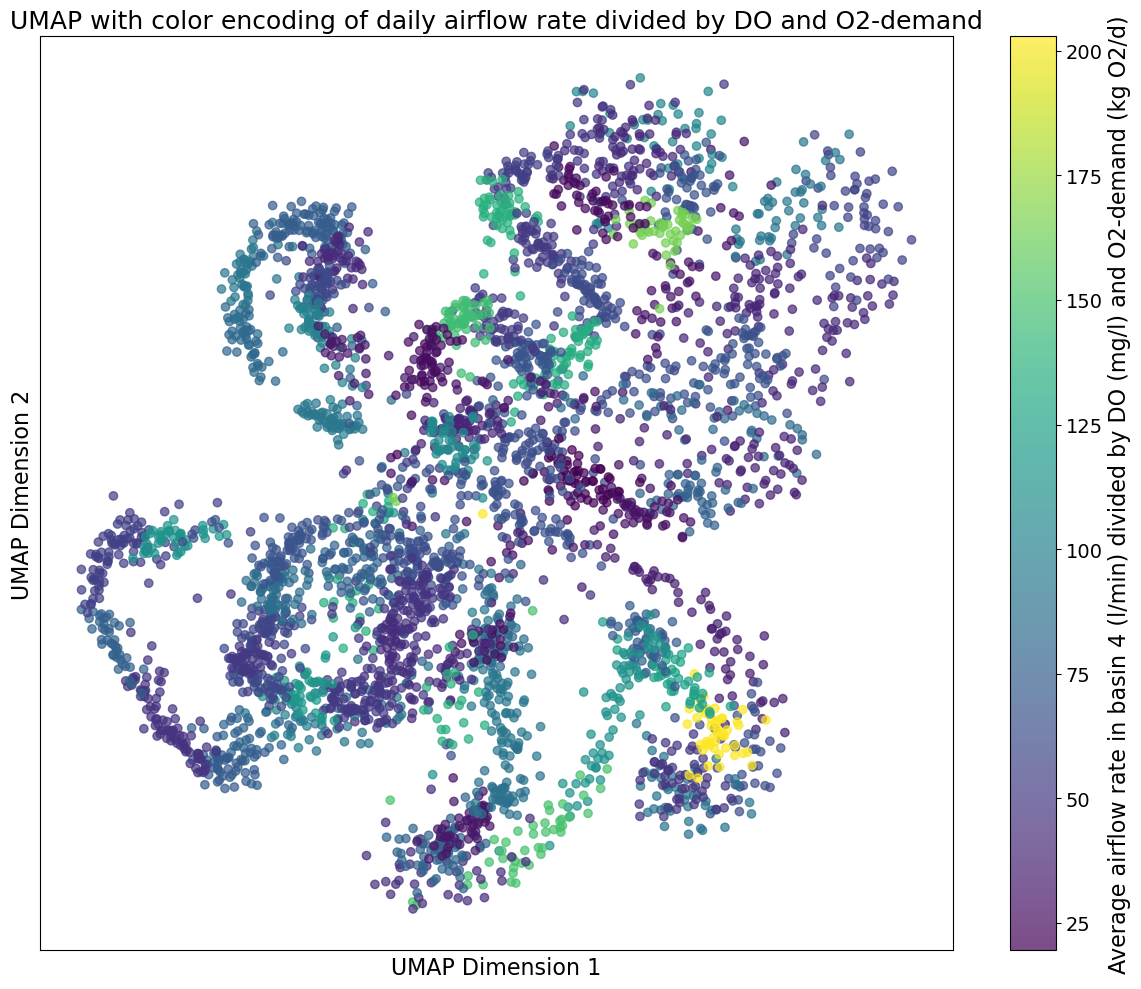

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# --- Zorg dat dit al bestaat ---
# X_umap: 2D array met bestaande UMAP-coördinaten (bijv. van airflow plot)
# image_labels2: nieuwe labels (bijv. airflow / DO)
# labels: lijst met datums van je afbeeldingen (zoals eerder)
# Opgelet: je moet deze code uitvoeren NA de code waar je image_labels2 maakt

# 1. Filter op geldige entries
valid_indices = [i for i, label in enumerate(image_labels4) if label is not None]
image_labels_filtered = [image_labels4[i] for i in valid_indices]
X_umap_filtered = X_umap[valid_indices]

# 2. Plot met aangepaste kleurenschaal
colormap = plt.get_cmap("viridis")
norm = plt.Normalize(vmin=min(image_labels_filtered), vmax=max(image_labels_filtered))

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_umap_filtered[:, 0], X_umap_filtered[:, 1],
                      c=image_labels_filtered, cmap=colormap, norm=norm, alpha=0.7)

# As- en titellabels
plt.xlabel("UMAP Dimension 1", fontsize=16)
plt.ylabel("UMAP Dimension 2", fontsize=16)
plt.title("UMAP with color encoding of daily airflow rate divided by DO and O2-demand", fontsize=18)

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Average airflow rate in basin 4 (l/min) divided by DO (mg/l) and O2-demand (kg O2/d)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Asnummers verwijderen
plt.xticks([])
plt.yticks([])

# Layout en opslaan
plt.tight_layout()
plt.savefig("UMAPDailyAirflowDOO2DemandBasin4oldnew.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [42]:
scenariosdates = pd.read_csv("unique_microscope_image_dates.csv", parse_dates=["Date"])

scenariosdates = scenariosdates[
    (scenariosdates["Date"] >= "2025-01-23") &
    (scenariosdates["Date"] <= "2025-02-19")
]

scenariosdates.loc[scenariosdates["Date"] == "2025-01-23", "Scenario"] = "Scenario 1"

scenariosdates.loc[(scenariosdates["Date"] >= "2025-01-27") & (scenariosdates["Date"] <= "2025-01-29") , "Scenario"] = "Scenario 2"

scenariosdates.loc[(scenariosdates["Date"] >= "2025-02-03") & (scenariosdates["Date"] <= "2025-02-05") , "Scenario"] = "Scenario 3"

scenariosdates.loc[(scenariosdates["Date"] >= "2025-02-10") & (scenariosdates["Date"] <= "2025-02-13") , "Scenario"] = "Scenario 4"

scenariosdates.loc[(scenariosdates["Date"] >= "2025-02-17") & (scenariosdates["Date"] <= "2025-02-19") , "Scenario"] = "Scenario 5"
print(scenariosdates)

         Date    Scenario
73 2025-01-23  Scenario 1
74 2025-01-27  Scenario 2
75 2025-01-28  Scenario 2
76 2025-01-29  Scenario 2
77 2025-02-03  Scenario 3
78 2025-02-04  Scenario 3
79 2025-02-05  Scenario 3
80 2025-02-10  Scenario 4
81 2025-02-11  Scenario 4
82 2025-02-12  Scenario 4
83 2025-02-13  Scenario 4
84 2025-02-17  Scenario 5
85 2025-02-18  Scenario 5
86 2025-02-19  Scenario 5


In [43]:
scenariosdates['Date'] = pd.to_datetime(scenariosdates['Date']).dt.date

scenarionumber_dict = dict(zip(scenariosdates['Date'], scenariosdates['Scenario']))

image_labels5 = []

for datum in labels:
    datum = pd.to_datetime(datum).date()
    scenario = scenarionumber_dict.get(datum, None)

    if scenario is not None:
        image_labels5.append(scenario)
    else:
        image_labels5.append(None)

image_labels5 = np.array(image_labels5)
print(image_labels5)
print(image_labels5.shape)

[None None None ... None None None]
(4566,)


/var/folders/9f/th88wdx51hg0ndwms7rmbwbm0000gn/T/ipykernel_1115/1891666798.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis", 5)  # 5 discrete kleuren uit viridis


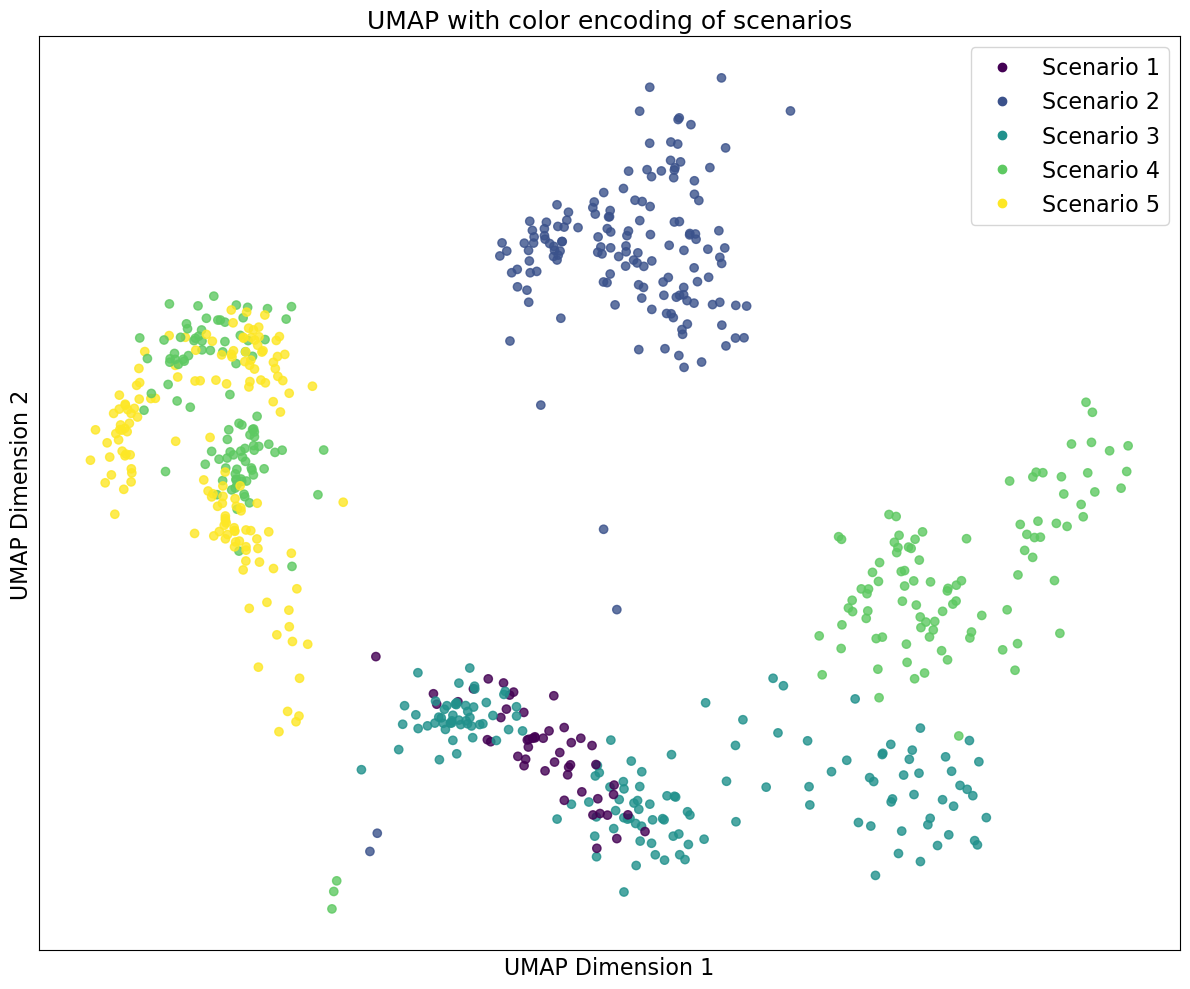

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

viridis = cm.get_cmap("viridis", 5)  # 5 discrete kleuren uit viridis
scenario_colors = [viridis(i) for i in range(5)]

# 1. Definitie: 5 scenario-namen (str of int)
scenario_labels = ["Scenario 1", "Scenario 2", "Scenario 3", "Scenario 4", "Scenario 5"]
colormap = ListedColormap(scenario_colors)

# 2. Filter op geldige indices (zoals jij al doet)
valid_indices = [i for i, label in enumerate(image_labels5) if label is not None]
image_labels_filtered = [image_labels5[i] for i in valid_indices]
X_umap_filtered = X_umap[valid_indices]

# 3. Zet labels om naar indices op basis van de volgorde in scenario_labels
label_to_index = {name: i for i, name in enumerate(scenario_labels)}
numeric_labels = [label_to_index[label] for label in image_labels_filtered]

# 4. Plot met discrete kleuren
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_umap_filtered[:, 0], X_umap_filtered[:, 1],
                      c=numeric_labels, cmap=colormap, alpha=0.8)

# 5. Legende maken
handles = [plt.Line2D([0], [0], marker='o', linestyle='', color=color, label=scenario)
           for scenario, color in zip(scenario_labels, scenario_colors)]
plt.legend(handles=handles, fontsize=16, title_fontsize=16)

# Labels
plt.xlabel("UMAP Dimension 1", fontsize=16)
plt.ylabel("UMAP Dimension 2", fontsize=16)
plt.title("UMAP with color encoding of scenarios", fontsize=18)

# Verwijder ticks
plt.xticks([])
plt.yticks([])

# Opslaan en tonen
plt.tight_layout()
plt.savefig("UMAPScenarios.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [45]:
residuals = pd.read_csv("airflow_residueel_per_dag.csv", parse_dates=["Date"])

residuals['Date'] = pd.to_datetime(residuals['Date']).dt.date

residuals_dict = dict(zip(residuals['Date'], residuals['airflow_residueel']))

image_labels6 = []

for datum in labels:
    datum = pd.to_datetime(datum).date()
    residual = residuals_dict.get(datum, None)

    if residual is not None:
        image_labels6.append(residual)
    else:
        image_labels6.append(None)

image_labels6 = np.array(image_labels6)
print(image_labels6)
print(image_labels6.shape)

[216.85799535 216.85799535 216.85799535 ...   5.10871854   5.10871854
   5.10871854]
(4566,)


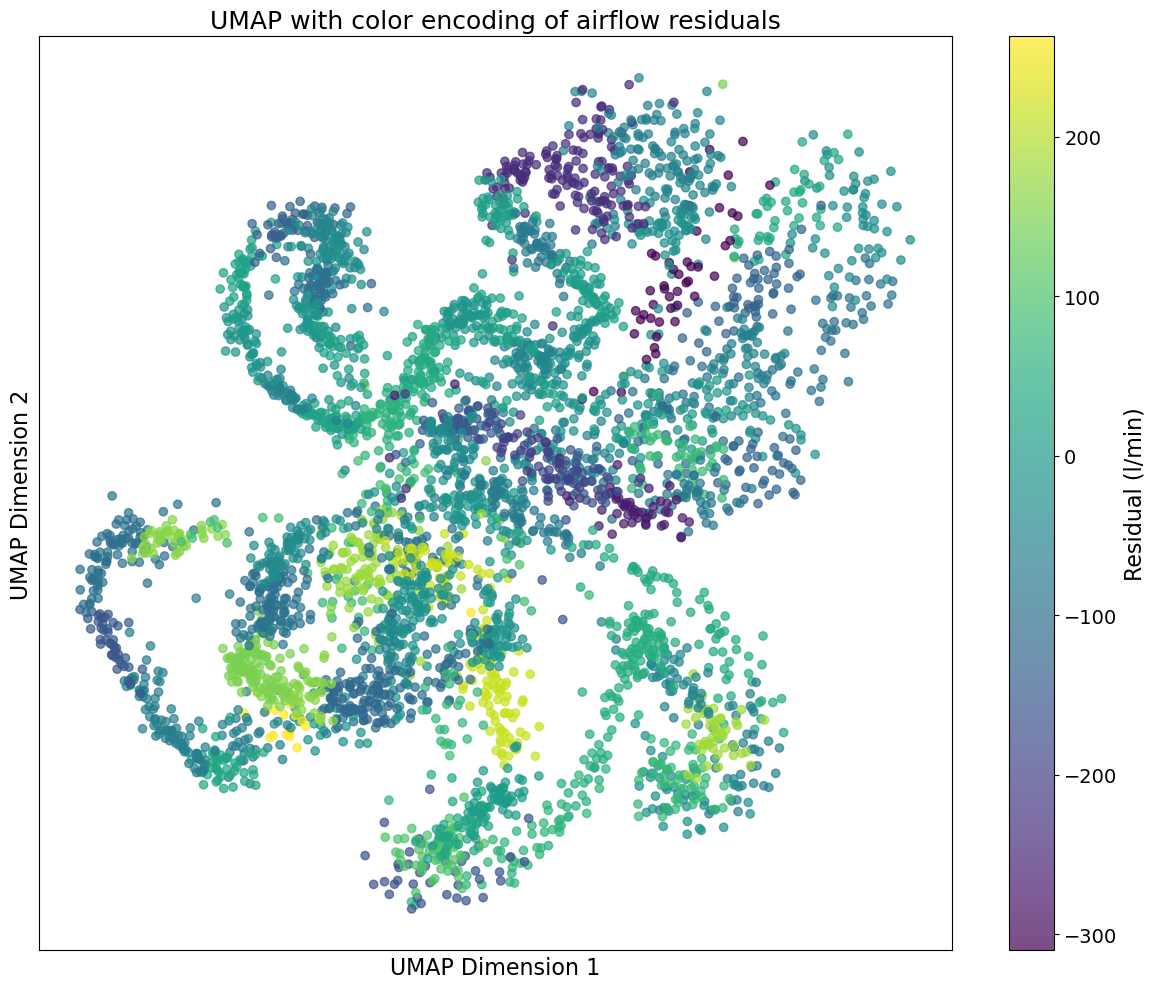

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Filter op geldige entries
valid_indices = [i for i, label in enumerate(image_labels6) if label is not None]
image_labels_filtered = [image_labels6[i] for i in valid_indices]
X_umap_filtered = X_umap[valid_indices]

# 2. Plot met aangepaste kleurenschaal
colormap = plt.get_cmap("viridis")
norm = plt.Normalize(vmin=min(image_labels_filtered), vmax=max(image_labels_filtered))

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_umap_filtered[:, 0], X_umap_filtered[:, 1],
                      c=image_labels_filtered, cmap=colormap, norm=norm, alpha=0.7)

# As- en titellabels
plt.xlabel("UMAP Dimension 1", fontsize=16)
plt.ylabel("UMAP Dimension 2", fontsize=16)
plt.title("UMAP with color encoding of airflow residuals", fontsize=18)

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Residual (l/min)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Asnummers verwijderen
plt.xticks([])
plt.yticks([])

# Layout en opslaan
plt.tight_layout()
plt.savefig("UMAPresiduals.pdf", format='pdf', bbox_inches='tight')
plt.show()